In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 6.1 MB/s 
     |████████████████████████████████| 209 kB 8.8 MB/s 
     |████████████████████████████████| 81 kB 6.1 MB/s 
     |████████████████████████████████| 78 kB 4.0 MB/s 
     |████████████████████████████████| 147 kB 46.5 MB/s 
     |████████████████████████████████| 112 kB 43.8 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=a2a90bf89780447715d64524f80c1b7ac157b5123242f4467232ed9e5e2b03a2
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import chain, combinations
import optuna

In [ ]:
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,f1_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor,XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile

import torch
import torch.nn as nn

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!mkdir aug-tabular-playground

In [ ]:
!kaggle competitions download -c tabular-playground-series-aug-2022

  0% 0.00/2.27M [00:00<?, ?B/s]
100% 2.27M/2.27M [00:00<00:00, 135MB/s]


In [ ]:
from zipfile import ZipFile

file_name = "tabular-playground-series-aug-2022.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zipper:
    # printing all the contents of the zip file
    #zipper.printdir()
    zipper.extractall('aug-tabular-playground')
zipper.close()

In [ ]:
df_org=pd.read_csv("/content/aug-tabular-playground/train.csv")

In [ ]:
df_test=pd.read_csv("/content/aug-tabular-playground/test.csv")

In [ ]:
df_org['attribute_0_material_5'] = np.where(df_org['attribute_0']=='material_5', 1, 0)
df_org['attribute_0_material_7'] = np.where(df_org['attribute_0']=='material_7', 1, 0)

In [ ]:
df_test['attribute_0_material_5'] = np.where(df_test['attribute_0']=='material_5', 1, 0)
df_test['attribute_0_material_7'] = np.where(df_test['attribute_0']=='material_7', 1, 0)

In [ ]:
df_org["datasource"]="train"
df_test["datasource"]="test"

In [ ]:
df_test.tail()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,attribute_0_material_5,attribute_0_material_7,source
20770,47340,I,144.74,material_7,material_5,9,5,0,4,9,...,19.771,11.562,17.246,15.131,15.209,NaN,696.466,0,1,test
20771,47341,I,74.53,material_7,material_5,9,5,4,8,7,...,15.694,13.564,15.494,15.296,13.812,16.501,613.249,0,1,test
20772,47342,I,67.73,material_7,material_5,9,5,10,11,2,...,20.612,11.134,16.519,15.525,14.175,17.728,783.349,0,1,test
20773,47343,I,126.15,material_7,material_5,9,5,8,16,11,...,19.496,9.319,15.817,17.403,16.437,15.179,745.210,0,1,test
20774,47344,I,85.97,material_7,material_5,9,5,0,11,11,...,17.924,13.726,14.605,17.460,16.261,16.482,647.980,0,1,test


In [ ]:
features = ['attribute_0_material_5','attribute_0_material_7','loading', 'measurement_0', 'measurement_1', 'measurement_2',
                'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17']

In [ ]:
data_combined=pd.concat([df_org[features+['datasource']],
                         df_test[features+['datasource']]],
                        ignore_index=True)



In [ ]:
data_combined2=pd.concat([df_org[features+['datasource']],
                         df_test[features+['datasource']]],
                        axis=1)

In [ ]:
data_combined2["measurement_0"].value_counts()

ValueError: ignored

In [ ]:
data_combined.shape

(47345, 22)

In [ ]:
features = ['attribute_0_material_5','attribute_0_material_7','loading', 'measurement_0', 'measurement_1', 'measurement_2',
                'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17']
cat_features=['attribute_0_material_5','attribute_0_material_7']
num_features = ['loading', 'measurement_0', 'measurement_1', 'measurement_2',
                'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17']

In [ ]:
N_NEIGHBORS=5
imputer=KNNImputer(n_neighbors=N_NEIGHBORS)
X_train_numpy=imputer.fit_transform(data_combined.loc[(data_combined["datasource"]=="train"),num_features])
X_test_numpy=imputer.transform(data_combined.loc[(data_combined["datasource"]=="test"),num_features])

scaler=MinMaxScaler()
X_train_numpy=scaler.fit_transform(X_train_numpy)
X_test_numpy=scaler.transform(X_test_numpy)


X_combined=np.vstack((X_train_numpy,X_test_numpy))
X_combined_df=pd.DataFrame(X_combined,columns=num_features)
X_combined_df["datasource"]=data_combined["datasource"]



In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=1001, perplexity=30, method='barnes_hut', n_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(X_combined_df[num_features]) # this will either fail or take a while (most likely overnight)



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 47345 samples in 0.002s...
[t-SNE] Computed neighbors for 47345 samples in 46.005s...
[t-SNE] Computed conditional probabilities for sample 1000 / 47345
[t-SNE] Computed conditional probabilities for sample 2000 / 47345
[t-SNE] Computed conditional probabilities for sample 3000 / 47345
[t-SNE] Computed conditional probabilities for sample 4000 / 47345
[t-SNE] Computed conditional probabilities for sample 5000 / 47345
[t-SNE] Computed conditional probabilities for sample 6000 / 47345
[t-SNE] Computed conditional probabilities for sample 7000 / 47345
[t-SNE] Computed conditional probabilities for sample 8000 / 47345
[t-SNE] Computed conditional probabilities for sample 9000 / 47345
[t-SNE] Computed conditional probabilities for sample 10000 / 47345
[t-SNE] Computed conditional probabilities for sample 11000 / 47345
[t-SNE] Computed conditional probabilities for sample 12000 / 47345
[t-SNE] Computed conditional probabilities for sa

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 113.815384
[t-SNE] KL divergence after 1000 iterations: 5.179020


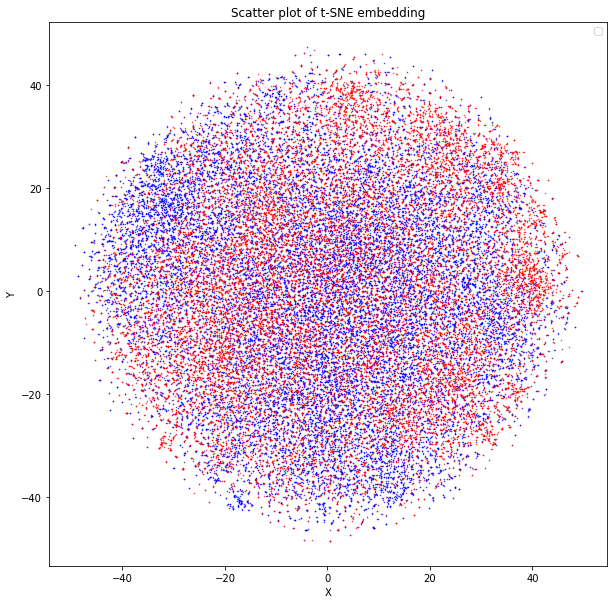

In [ ]:
X_tsne_df=pd.DataFrame({'V1':X_tsne[:,0],
                        'V2':X_tsne[:,1],
                        'y':X_combined_df['datasource'].values.tolist()})

plt.figure(2, figsize=(10, 10))
colors=['blue','red']
for color, i  in zip(colors, ["train", "test"] ):
        plt.scatter(X_tsne_df.loc[X_tsne_df['y'] == i, 'V1'], X_tsne_df.loc[X_tsne_df['y'] == i, 'V2'], color=color, s=1,
                                    alpha=.8, marker='.')
        plt.legend(loc='best', shadow=False, scatterpoints=3)
        plt.title('Scatter plot of t-SNE embedding')
        plt.xlabel('X')
        plt.ylabel('Y')

# plt.savefig('t-SNE-porto-01.png', dpi=150)
plt.show()

In [ ]:
from sklearn.cluster import KMeans

#X_train_pca_df=pd.DataFrame(X_train_pca,columns=pca_col_list)
#X_test_pca_df=pd.DataFrame(X_test_pca,columns=pca_col_list)
kmeans = KMeans(n_clusters=5)
X_combined_df["cluster"] = kmeans.fit_predict(X_combined_df[num_features])


In [ ]:
X_combined_df.groupby(['cluster', 'datasource']).agg({'datasource': 'count'}).div(X_combined_df.groupby(['cluster']).agg({'datasource': 'count'}), level='cluster') * 100


datasource
cluster datasource            
0       test         43.907396
        train        56.092604
1       test         44.209742
        train        55.790258
2       test         44.523896
        train        55.476104
3       test         39.637896
        train        60.362104
4       test         47.214724
        train        52.785276

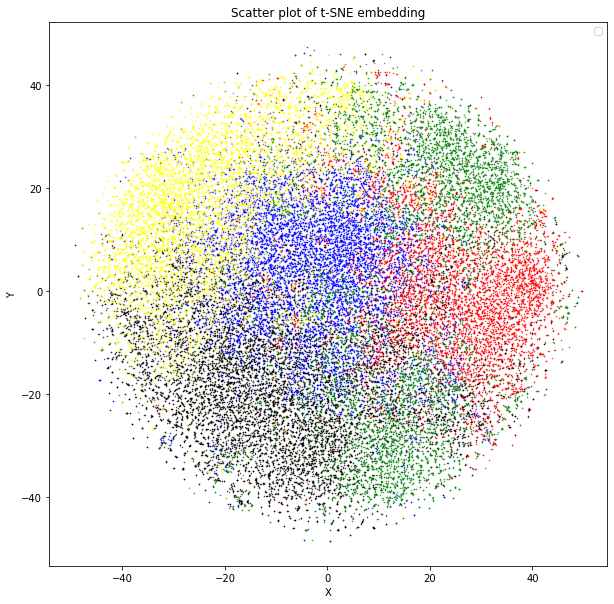

In [ ]:
X_tsne_df=pd.DataFrame({'V1':X_tsne[:,0],
                        'V2':X_tsne[:,1],
                        'y':X_combined_df['datasource'].values.tolist(),
                        'cluster':X_combined_df['cluster'].values.tolist()})

plt.figure(2, figsize=(10, 10))
colors=['blue','red','black','yellow','green']
for color, i  in zip(colors, [0,1,2,3,4] ):
        plt.scatter(X_tsne_df.loc[X_tsne_df['cluster'] == i, 'V1'], X_tsne_df.loc[X_tsne_df['cluster'] == i, 'V2'], color=color, s=1,
                                    alpha=.8, marker='.')
        plt.legend(loc='best', shadow=False, scatterpoints=3)
        plt.title('Scatter plot of t-SNE embedding')
        plt.xlabel('X')
        plt.ylabel('Y')

# plt.savefig('t-SNE-porto-01.png', dpi=150)
plt.show()

In [ ]:
X_combined_df.head()

,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,datasource,cluster
0,0.133088,0.241379,0.275862,0.166667,0.540698,0.532091,0.392964,0.745016,0.506107,0.574854,...,0.496808,0.389483,0.802337,0.350080,0.431391,0.313848,0.346210,0.508342,train,0
1,0.146669,0.482759,0.103448,0.125000,0.563670,0.416706,0.603507,0.586543,0.641525,0.311059,...,0.655518,0.413840,0.527209,0.324960,0.477475,0.422536,0.412006,0.434827,train,3
2,0.139694,0.413793,0.034483,0.208333,0.542956,0.429920,0.498824,0.625850,0.637498,0.357509,...,0.477653,0.526899,0.690701,0.492345,0.721036,0.398499,0.572848,0.418088,train,3
3,0.192543,0.448276,0.068966,0.250000,0.441774,0.375177,0.695359,0.637064,0.619380,0.447381,...,0.533825,0.448896,0.388364,0.368773,0.487883,0.563009,0.519072,0.564060,train,3
4,0.439183,0.310345,0.068966,0.333333,0.714115,0.583058,0.525770,0.343339,0.447994,0.334808,...,0.589769,0.566887,0.581066,0.447602,0.275013,0.323351,0.466268,0.343276,train,2


In [ ]:
df_org.shape

(26570, 29)

In [ ]:
df_train_clustered=
df_test_clustered=

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_org[features], df_org['failure'], 
                                                    test_size=0.33,
                                                    random_state=13,
                                                    stratify=df_org['failure']) 

In [ ]:
df_test_check=X_combined_df.iloc[26571:,:-2]

In [ ]:
df_test.shape

(20775, 28)

In [ ]:
df_test_check.shape

(20774, 19)

In [ ]:
col_pair_list=sum([list(map(list, combinations(features, 2)))], [])
def get_interaction_features_pairs(df_org,col_pair_list):
    X_copy=df_org.copy()
    for col_pair in col_pair_list:
        col1,col2=col_pair
        new_col=f"{col1}_{col2}"
        X_copy[new_col]=X_copy[col1]*X_copy[col2]
    return X_copy

col_triplet_list=sum([list(map(list, combinations(features, 3)))], [])
def get_interaction_features_triplets(df_org,col_triplet_list):
    X_copy=df_org.copy()
    for col_triplet in col_triplet_list:
        col1,col2,col3=col_triplet
        new_col=f"{col1}_{col2}_{col3}"
        X_copy[new_col]=X_copy[col1]*X_copy[col2]*X_copy[col3]
    return X_copy

In [ ]:
N_NEIGHBORS=5
imputer=KNNImputer(n_neighbors=N_NEIGHBORS)
X_train_numpy=imputer.fit_transform(X_train[num_features])
X_test_numpy=imputer.transform(X_test[num_features])

scaler=MinMaxScaler()
X_train_numpy=scaler.fit_transform(X_train_numpy)
X_test_numpy=scaler.transform(X_test_numpy)

X_train_imputed=pd.concat([X_train[cat_features].copy().reset_index(drop=True),
                            pd.DataFrame(X_train_numpy,columns=num_features)],
                            axis=1)

X_test_imputed=pd.concat([X_test[cat_features].copy().reset_index(drop=True),
                            pd.DataFrame(X_test_numpy,columns=num_features)],
                            axis=1)

Text(0, 0.5, 'cumulative explained variance')

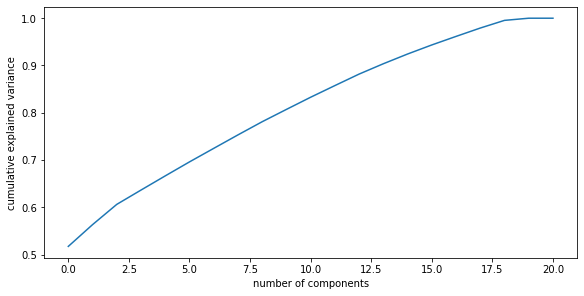

In [ ]:
from sklearn.decomposition import PCA
# initializing the PCA transformer and

pca = PCA().fit(X_train_imputed)

fig = plt.figure(constrained_layout=True, figsize=(8, 4))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:


X_train_new_feats=get_interaction_features_pairs(X_train_imputed,col_pair_list)
X_test_new_feats=get_interaction_features_pairs(X_test_imputed,col_pair_list)

#X_train_new_feats=get_interaction_features_triplets(X_train_new_feats,col_triplet_list)
#X_test_new_feats=get_interaction_features_triplets(X_test_new_feats,col_triplet_list)

selector = SelectKBest(mutual_info_classif, k=200)
X_train_reduced = selector.fit_transform(X_train_new_feats, y_train)
X_test_reduced = selector.transform(X_test_new_feats)

cols = selector.get_support(indices=True)
selected_columns = X_train_new_feats.iloc[:,cols].columns.tolist()

#X_train_reduced_df=pd.DataFrame(X_train_reduced,columns=selected_columns)

#X_test_reduced_df=pd.DataFrame(X_test_reduced,columns=selected_columns)

scaler2=MinMaxScaler()
X_train_numpy=scaler2.fit_transform(X_train_reduced)
X_test_numpy=scaler2.transform(X_test_reduced)

X_train_scaled = pd.DataFrame(X_train_numpy,columns=selected_columns)

X_test_scaled = pd.DataFrame(X_test_numpy,columns=selected_columns)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys


In [ ]:
X_test_scaled.head()

,attribute_0_material_5,attribute_0_material_7,loading,measurement_1,measurement_5,measurement_7,measurement_8,measurement_11,measurement_14,measurement_15,...,measurement_13_measurement_14,measurement_13_measurement_15,measurement_13_measurement_16,measurement_13_measurement_17,measurement_14_measurement_15,measurement_14_measurement_16,measurement_14_measurement_17,measurement_15_measurement_16,measurement_15_measurement_17,measurement_16_measurement_17
0,0.0,1.0,0.181248,0.241379,0.673439,0.470675,0.667021,0.498293,0.542885,0.527671,...,0.320584,0.330273,0.205455,0.370636,0.373587,0.369564,0.486138,0.246039,0.563072,0.426509
1,0.0,1.0,0.181910,0.137931,0.449743,0.328815,0.587892,0.584870,0.473904,0.562881,...,0.409254,0.515223,0.283424,0.321576,0.347878,0.304315,0.251773,0.247576,0.356356,0.238696
2,0.0,1.0,0.382452,0.275862,0.515184,0.566609,0.217870,0.718492,0.563625,0.506978,...,0.435376,0.415087,0.297821,0.304363,0.372649,0.425178,0.316844,0.261956,0.339620,0.296708
3,0.0,1.0,0.316813,0.379310,0.510479,0.647027,0.349575,0.699598,0.626529,0.465351,...,0.394176,0.310317,0.131130,0.305423,0.380226,0.255502,0.433942,0.129985,0.384079,0.197623
4,0.0,1.0,0.323781,0.172414,0.534859,0.401959,0.488051,0.484483,0.477779,0.407010,...,0.297416,0.268546,0.171006,0.259123,0.253602,0.256802,0.283748,0.149843,0.288045,0.223343


Text(0, 0.5, 'cumulative explained variance')

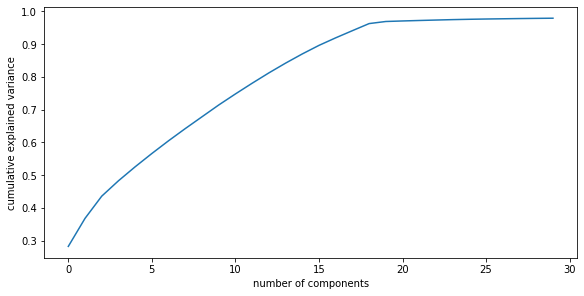

In [ ]:
from sklearn.decomposition import PCA
# initializing the PCA transformer and

pca = PCA(n_components=30).fit(X_train_scaled)

fig = plt.figure(constrained_layout=True, figsize=(8, 4))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
pca20=PCA(n_components=20).fit(X_train_scaled)
X_train_pca = pca20.fit_transform(X_train_scaled)

X_test_pca = pca20.transform(X_test_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17801 samples in 0.001s...
[t-SNE] Computed neighbors for 17801 samples in 7.515s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17801
[t-SNE] Computed conditional probabilities for sample 2000 / 17801
[t-SNE] Computed conditional probabilities for sample 3000 / 17801
[t-SNE] Computed conditional probabilities for sample 4000 / 17801
[t-SNE] Computed conditional probabilities for sample 5000 / 17801
[t-SNE] Computed conditional probabilities for sample 6000 / 17801
[t-SNE] Computed conditional probabilities for sample 7000 / 17801
[t-SNE] Computed conditional probabilities for sample 8000 / 17801
[t-SNE] Computed conditional probabilities for sample 9000 / 17801
[t-SNE] Computed conditional probabilities for sample 10000 / 17801
[t-SNE] Computed conditional probabilities for sample 11000 / 17801
[t-SNE] Computed conditional probabilities for sample 12000 / 17801
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.505493


[t-SNE] KL divergence after 1000 iterations: 3.856799


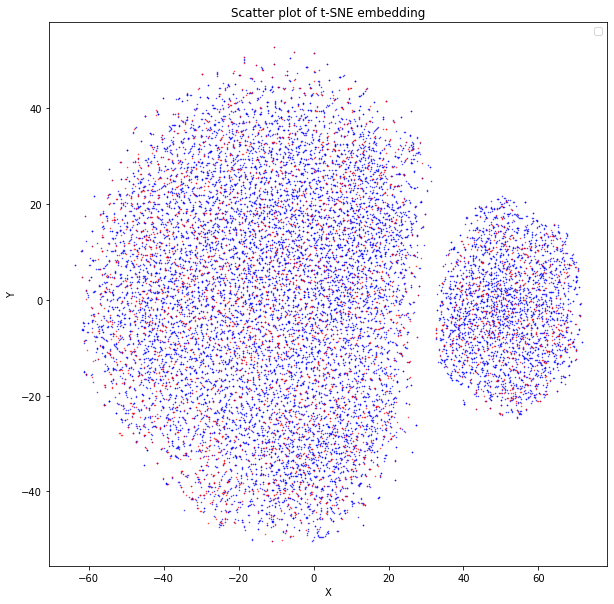

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=1001, perplexity=30, method='barnes_hut', n_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(X_train_pca) # this will either fail or take a while (most likely overnight)
X_tsne_df=pd.DataFrame({'V1':X_tsne[:,0],
                        'V2':X_tsne[:,1],
                        'y':y_train.tolist()})

plt.figure(2, figsize=(10, 10))
colors=['blue','red']
for color, i  in zip(colors, [0, 1] ):
        plt.scatter(X_tsne_df.loc[X_tsne_df['y'] == i, 'V1'], X_tsne_df.loc[X_tsne_df['y'] == i, 'V2'], color=color, s=1,
                                    alpha=.8, marker='.')
        plt.legend(loc='best', shadow=False, scatterpoints=3)
        plt.title('Scatter plot of t-SNE embedding')
        plt.xlabel('X')
        plt.ylabel('Y')

# plt.savefig('t-SNE-porto-01.png', dpi=150)
plt.show()

In [ ]:
pca_col_list=[]
for i in range(20):
    pca_col_list.append(f"V{i}")

In [ ]:
X_test_tsne_df=tsne.transform(X_test_pca)

AttributeError: ignored

In [ ]:
from sklearn.cluster import KMeans

#X_train_pca_df=pd.DataFrame(X_train_pca,columns=pca_col_list)
#X_test_pca_df=pd.DataFrame(X_test_pca,columns=pca_col_list)
kmeans = KMeans(n_clusters=2,algorithm="elkan")
X_tsne_df["cluster"] = kmeans.fit_predict(X_tsne_df[['V2','V2']])

#X_test_tsne_df["cluster"] = kmeans.predict(X_test_pca_df[['V2','V2']])



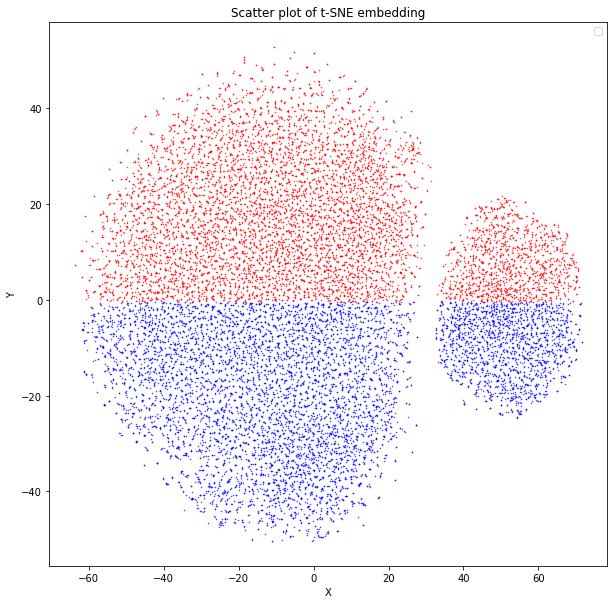

In [ ]:
plt.figure(2, figsize=(10, 10))
colors=['blue','red']
for color, i  in zip(colors, [0, 1] ):
        plt.scatter(X_tsne_df.loc[X_tsne_df['cluster'] == i, 'V1'], X_tsne_df.loc[X_tsne_df['cluster'] == i, 'V2'], color=color, s=1,
                                    alpha=.8, marker='.')
        plt.legend(loc='best', shadow=False, scatterpoints=3)
        plt.title('Scatter plot of t-SNE embedding')
        plt.xlabel('X')
        plt.ylabel('Y')

# plt.savefig('t-SNE-porto-01.png', dpi=150)
plt.show()

In [ ]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=2,
                                assign_labels='discretize',
                                 random_state=0).fit(X_tsne_df[['V2','V2']])
X_tsne_df['cluster_sp']=clustering.labels_

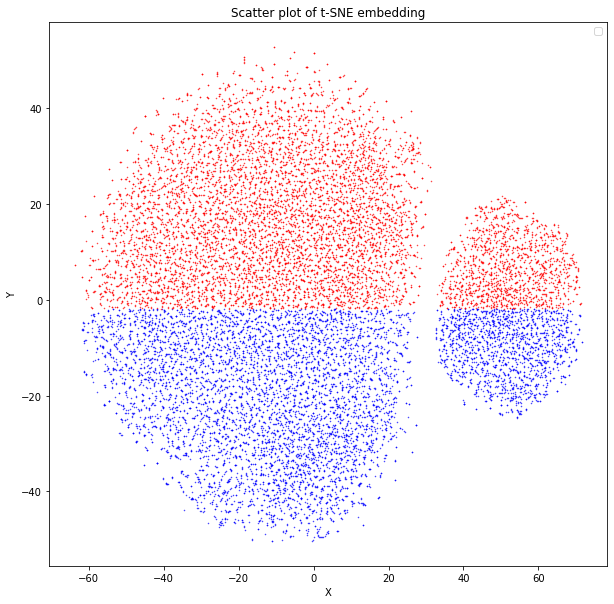

In [ ]:
plt.figure(2, figsize=(10, 10))
colors=['blue','red']
for color, i  in zip(colors, [0, 1] ):
        plt.scatter(X_tsne_df.loc[X_tsne_df['cluster_sp'] == i, 'V1'], X_tsne_df.loc[X_tsne_df['cluster_sp'] == i, 'V2'], color=color, s=1,
                                    alpha=.8, marker='.')
        plt.legend(loc='best', shadow=False, scatterpoints=3)
        plt.title('Scatter plot of t-SNE embedding')
        plt.xlabel('X')
        plt.ylabel('Y')

# plt.savefig('t-SNE-porto-01.png', dpi=150)
plt.show()

In [ ]:
class TabAugDataset(torch.utils.data.Dataset):
    def __init__(self,features,target):
        #features.reset_index(drop=True,inplace=True)
        self.features=features
        if target is not None:
            self.target=target
            
    def __getitem__(self,idx):
        if self.target is not None:
            return {"X": torch.tensor(self.features[idx,:],dtype=torch.float),
                    "y": torch.tensor(self.target[idx],dtype=torch.float)}
    def __len__(self):
        return self.features.shape[0]

In [ ]:
def create_folds(df_org):
    df=df_org.copy()
    df=df.sample(frac=1,random_state=2)
    df.reset_index(drop=True,inplace=True)
    df=df.sample(frac=1)
    df["folds"]=-1
    kf=StratifiedKFold(n_splits=5)
    for i,(train_idx,valid_idx) in enumerate(kf.split(df.iloc[:,1:-1],df.iloc[:,-1])):
               
        df.loc[valid_idx,"folds"]=i
    return df

In [ ]:
df_folds=create_folds(df_org)

In [ ]:
class CustomModel3(torch.nn.Module):
    def __init__(self,n_features,n_targets,hidden_size_1,hidden_size_2,hidden_size_3,hidden_size_4,
                 dropout_1,dropout_2,dropout_3,dropout_4,dropout_5):
        super().__init__()
        
        self.fc1=nn.Linear(n_features,hidden_size_1)
        self.drop1=nn.Dropout(dropout_1)
        self.relu1=nn.ReLU()
        self.fc2=nn.Linear(hidden_size_1,hidden_size_2)
        self.drop2=nn.Dropout(dropout_2)
        self.relu2=nn.ReLU()
        self.fc3=nn.Linear(hidden_size_2,hidden_size_3)
        self.drop3=nn.Dropout(dropout_3)
        self.relu3=nn.ReLU()
        self.fc4=nn.Linear(hidden_size_3,hidden_size_4)
        self.drop4=nn.Dropout(dropout_4)
        self.relu4=nn.ReLU()
        self.fc5=nn.Linear(hidden_size_4,n_targets)
        self.drop5=nn.Dropout(dropout_5)
        self.tanh=nn.Tanh()
        
    def forward(self,x):
        
        out_1=self.relu1(self.drop1(self.fc1(x)))
        out_2=self.relu2(self.drop2(self.fc2(out_1)))
        out_3=self.relu3(self.drop3(self.fc3(out_2)))
        out_4=self.relu4(self.drop4(self.fc4(out_3)))
        out_final=self.tanh(self.drop5(self.fc5(out_4)))
        
        return out_final

In [ ]:
class TrainValidateOneEpoch:
    def __init__(self,model,optimizer,device):
        self.model=model
        self.optimizer=optimizer
        self.device=device
        
    @staticmethod    
    def loss_fn(outputs,targets):
        return nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4))(outputs,targets)
        
    def train(self,data_loader):
        self.model.train()
        running_loss=0
        y_pred=[]
        y_true=[]
        for data in data_loader:
            self.optimizer.zero_grad()
            inputs=data["X"].to(self.device)
            targets=data["y"].to(self.device)
            outputs=self.model(inputs)
            loss=self.loss_fn(outputs,targets.view(-1,1))
            loss.backward()
            y_pred.extend(outputs.detach().cpu().numpy())
            y_true.extend(targets.view(-1,1).detach().cpu().numpy())
            self.optimizer.step()
            running_loss+=loss.item()
        return running_loss/len(data_loader),roc_auc_score(y_true,y_pred)
        
    def evaluate(self,data_loader):
        self.model.eval()
        with torch.no_grad():
            running_loss=0
            y_pred=[]
            y_true=[]
            for data in data_loader:
                inputs=data["X"].to(self.device)
                targets=data["y"].to(self.device)
                outputs=self.model(inputs)
                loss=self.loss_fn(outputs,targets.view(-1,1))
                y_pred.extend(outputs.detach().cpu().numpy())
                y_true.extend(targets.view(-1,1).detach().cpu().numpy())
                running_loss+=loss.item()
        return running_loss/len(data_loader),roc_auc_score(y_true,y_pred)

In [ ]:
col_pair_list=sum([list(map(list, combinations(features, 2)))], [])
def get_interaction_features_pairs(df_org,col_pair_list):
    X_copy=df_org.copy()
    for col_pair in col_pair_list:
        col1,col2=col_pair
        new_col=f"{col1}_{col2}"
        X_copy[new_col]=X_copy[col1]*X_copy[col2]
    return X_copy

col_triplet_list=sum([list(map(list, combinations(features, 3)))], [])
def get_interaction_features_triplets(df_org,col_triplet_list):
    X_copy=df_org.copy()
    for col_triplet in col_triplet_list:
        col1,col2,col3=col_triplet
        new_col=f"{col1}_{col2}_{col3}"
        X_copy[new_col]=X_copy[col1]*X_copy[col2]*X_copy[col3]
    return X_copy

In [ ]:
df_folds.shape

(26570, 30)

In [ ]:
X_test=df_org.loc[df_folds["folds"]==0].reset_index(drop=True)
X_train=df_org.loc[df_folds["folds"]!=0].reset_index(drop=True)



y_train=X_train["failure"]
y_test=X_test["failure"]


N_NEIGHBORS=5
imputer=KNNImputer(n_neighbors=N_NEIGHBORS)
X_train_numpy=imputer.fit_transform(X_train[num_features])
X_test_numpy=imputer.transform(X_test[num_features])
X_train_imputed=pd.concat([X_train[cat_features],
                            pd.DataFrame(X_train_numpy,columns=num_features)],
                            ignore_index=True,
                            axis=1)

X_test_imputed=pd.concat([X_test[cat_features],
                            pd.DataFrame(X_test_numpy,columns=num_features)],
                            ignore_index=True,
                             axis=1)

scaler=MinMaxScaler()
X_train_numpy=scaler.fit_transform(X_train_imputed)
X_test_numpy=scaler.transform(X_test_imputed)

print(X_test_numpy.shape)

(5314, 21)


In [ ]:
print(X_train_numpy.shape)

(21256, 21)


In [ ]:
pd.DataFrame(X_train_numpy,columns=features).head()

,attribute_0_material_5,attribute_0_material_7,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,1.0,0.0,0.261684,0.103448,0.275862,0.125000,0.504528,0.509565,0.729503,0.543611,...,0.220140,0.593049,0.505397,0.554746,0.467190,0.267614,0.579883,0.304424,0.661433,0.525898
1,1.0,0.0,0.112468,0.172414,0.103448,0.416667,0.453980,0.483788,0.636803,0.418781,...,0.405984,0.485670,0.452189,0.635860,0.622599,0.474499,0.396262,0.463904,0.423706,0.463916
2,1.0,0.0,0.310182,0.137931,0.310345,0.291667,0.739019,0.530729,0.669968,0.617354,...,0.345518,0.341071,0.622226,0.258290,0.609315,0.685105,0.481881,0.523638,0.310985,0.509024
3,1.0,0.0,0.089547,0.310345,0.068966,0.291667,0.376673,0.525573,0.543528,0.524128,...,0.296042,0.207625,0.558072,0.413537,0.471671,0.308720,0.593786,0.413352,0.297158,0.464307
4,1.0,0.0,0.212378,0.620690,0.448276,0.166667,0.544668,0.402116,0.488600,0.490145,...,0.447963,0.295422,0.384463,0.524471,0.601152,0.528969,0.491301,0.414790,0.468631,0.457152


In [ ]:
def run_training(df_org,fold,save_model=False):
    df=df_org.copy()
    
    
    X_test=df.loc[df["folds"]==fold].reset_index(drop=True)
    X_train=df.loc[df["folds"]!=fold].reset_index(drop=True)
    
    
    
    y_train=X_train["failure"]
    y_test=X_test["failure"]
    
    
    N_NEIGHBORS=5
    imputer=KNNImputer(n_neighbors=N_NEIGHBORS)
    X_train_numpy=imputer.fit_transform(X_train[num_features])
    X_test_numpy=imputer.transform(X_test[num_features])
    X_train_imputed=pd.concat([X_train[cat_features],
                               pd.DataFrame(X_train_numpy,columns=num_features)],
                               ignore_index=True,
                               axis=1)

    X_test_imputed=pd.concat([X_test[cat_features],
                              pd.DataFrame(X_test_numpy,columns=num_features)],
                              ignore_index=True,
                              axis=1)

    
    scaler=MinMaxScaler()
    X_train_numpy=scaler.fit_transform(X_train_imputed)
    X_test_numpy=scaler.transform(X_test_imputed)

    #print(X_test_numpy.shape)
    train_ds=TabAugDataset(features=X_train_numpy,target=y_train.to_numpy())
    valid_ds=TabAugDataset(features=X_test_numpy,target=y_test.to_numpy())
    
    train_dl=torch.utils.data.DataLoader(train_ds,batch_size=512,shuffle=True)
    valid_dl=torch.utils.data.DataLoader(valid_ds,batch_size=512,shuffle=False)
    
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    EPOCHS=200
    
    #print(X_train.shape[1])
    #model=CustomModel3(n_features=X_train_numpy.shape[1],
    #                  n_targets=1,
    #                  hidden_size_1=params["hidden_size_1"],
    #                  hidden_size_2=params["hidden_size_2"],
    #                  hidden_size_3=params["hidden_size_3"],
    #                  dropout_1=params["dropout_1"],
    #                  dropout_2=params["dropout_2"],
    #                  dropout_3=params["dropout_3"],
    #                  dropout_4=params["dropout_4"])

    model=CustomModel3(n_features=X_train_numpy.shape[1],
                      n_targets=1,
                      hidden_size_1=256,
                      hidden_size_2=128,
                      hidden_size_3=64,
                      hidden_size_4=16,
                      dropout_1=0.4,
                      dropout_2=0.4,
                      dropout_3=0.2,
                      dropout_4=0.15,
                      dropout_5=0.15)
    
    
    
    model.to(device)
    learning_rate=0.001
    optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
    training_loop=TrainValidateOneEpoch(model,optimizer,device)
    best_loss=np.Inf
    best_roc_auc=0
    early_stopping_iter=50
    early_stopping_counter=0
    
    for epoch in range(EPOCHS):
        train_loss,train_auc_roc=training_loop.train(train_dl)
        valid_loss,valid_auc_roc=training_loop.evaluate(valid_dl)
        print(f"Epoch: {epoch} train_loss:{train_loss}  valid_loss:{valid_loss}")
        print(f"Epoch: {epoch} train_auc_roc:{train_auc_roc}  valid_auc_roc:{valid_auc_roc}")
        if valid_loss<best_loss:
            best_loss=valid_loss
            best_roc_auc=valid_auc_roc
            if save_model:
                torch.save(model.state_dict(),f"model_{fold}.bin")
        else:
            early_stopping_counter+=1
        if  early_stopping_counter>early_stopping_iter:
            break
 
    return best_loss,best_roc_auc

In [ ]:
for j in range(5):
    scr,roc_auc=run_training(df_folds, j,  save_model=True)
    print(f"best lost:{scr} best roc_auc: {roc_auc}")


Epoch: 0 train_loss:1.1409850461142403  valid_loss:1.1203023086894641
Epoch: 0 train_auc_roc:0.499188253975077  valid_auc_roc:0.5435455782077164
Epoch: 1 train_loss:1.136740812233516  valid_loss:1.1187489249489524
Epoch: 1 train_auc_roc:0.5178364731112745  valid_auc_roc:0.5600243031789078
Epoch: 2 train_loss:1.1355468801089696  valid_loss:1.1168644319881091
Epoch: 2 train_auc_roc:0.527982483416763  valid_auc_roc:0.5662956930088289
Epoch: 3 train_loss:1.1337678177016122  valid_loss:1.1126242876052856
Epoch: 3 train_auc_roc:0.5411187574891005  valid_auc_roc:0.5722625349818484
Epoch: 4 train_loss:1.1294839467321123  valid_loss:1.1110474846579812
Epoch: 4 train_auc_roc:0.5535643007895503  valid_auc_roc:0.5745015898871051
Epoch: 5 train_loss:1.1287431518236797  valid_loss:1.1114780902862549
Epoch: 5 train_auc_roc:0.5564223101070411  valid_auc_roc:0.5731659980765398
Epoch: 6 train_loss:1.1250214860552834  valid_loss:1.1119291240518743
Epoch: 6 train_auc_roc:0.5664861625446749  valid_auc_roc:

In [ ]:
def objective(trial):
    params={
       # "hidden_size_1":trial.suggest_int("hidden_size_1",5,64),
       # "hidden_size_2":trial.suggest_int("hidden_size_2",3,64),
       # "hidden_size_3":trial.suggest_int("hidden_size_3",3,64),
        "dropout_1":trial.suggest_uniform("dropout_1",0.1,0.7),
        "dropout_2":trial.suggest_uniform("dropout_2",0.1,0.7),
        "dropout_3":trial.suggest_uniform("dropout_3",0.1,0.7),
        "dropout_4":trial.suggest_uniform("dropout_4",0.1,0.7),
        "learning_rate":trial.suggest_loguniform("learning_rate",1e-6,1e-2)
    }
    all_losses=[]
    for f_ in range(5):
        temp_loss=run_training(df_folds,f_,params)
        all_losses.append(temp_loss)
        
    return np.mean(all_losses)

In [ ]:
study=optuna.create_study(direction="minimize")
study.optimize(objective,n_trials=50)
print("best trial\n")
trial_=study.best_trial
print(trial_.values)
print(trial_.params)

scores=0
for j in range(5):
    scr=run_training(df_folds, j, trial_.params, save_model=True)
    scores+=scr
print(scores/5)